In [1]:
import numpy as np
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import hrvanalysis

## Spectral Features

In [2]:
def spectral_features_resp(signal, fs):
    """
    INPUT:
        signal -> respiration signal for one participant, one video
        fs -> sampling frequency
    RETURNS:
        features -> maximum amplitude, mean value in band 0.2-0.5 Hz
    """
    #import numpy as numpy
    #import matplotlib.pyplot as plt

    p_s = np.abs(np.fft.fft(signal))**2
    t = 1/fs

    freqs = np.fft.fftfreq(len(signal), t)
    idx = np.argsort(freqs)
    freqs = freqs[idx]

    max_amp = max(p_s)
    ps_05 = p_s[freqs<0.5]
    mean_band = np.mean(ps_05[ps_05>0.2])

    pxx, freqs_p = plt.psd(signal, Fs=fs, return_line=None)
    max_psd = max(pxx)
    pxx_60 = pxx[freqs_p<60]
    mean_psd_band = np.mean(pxx_60[pxx_60>40])
 

    return [max_amp, mean_band, max_psd, mean_psd_band]

## Breathing Rate Variability Features

In [3]:
def get_intervals(peaks):
    intervals = np.zeros(len(peaks)-1)
    j = 0
    for i in range(len(peaks)-1):
        intervals[j] = peaks[i+1]-peaks[i]
        j += 1

    return intervals

In [4]:
def brv_features_resp(signal, fs):
    """
    INPUT:
        signal -> respiration signal for one participant, one video
        fs -> sampling frequency
    """
    #import hrvanalysis
    #from scipy.signal import butter, lfilter, find_peaks

    fn = 0.5*fs

    b, a = butter(2, 0.5/fn, btype='low')
    filtered = lfilter(b, a, signal)

    peaks, _ = find_peaks(filtered, distance=250)

    intervals = get_intervals(peaks)

    td_features = hrvanalysis.get_time_domain_features(intervals)
    sd_features = hrvanalysis.get_frequency_domain_features(intervals)

    return td_features, sd_features

In [41]:
def standard(x):
    """
    INPUT:
        x -> non standardized data
    RETURNS:
        std -> standardized data (mean=0, std=1 for each feature)
    """
    std = np.zeros(x.shape)
    if len(x.shape) > 1:
        for i in range(x.shape[1]):
            std[:, i] = (x[:, i]-np.mean(x[:, i]))/np.std(x[:, i])
    else:
        std = (x-np.mean(x))/np.std(x)
    return std

## Loading respiration signal

In [442]:
curr='32'

In [443]:
RESP_CH = 37

In [444]:
resp_signals = []

In [445]:
path = os.path.dirname(os.path.abspath('')) + '\dataset\signals_processed\DEAP\s{}.dat'.format(curr)
with open(path, 'rb') as f:
    data = pickle.load(f, encoding = 'bytes')

data = data[b'data']
resp_signal = data[:, RESP_CH, :]

In [446]:
spect_feat = np.zeros((40, 4))

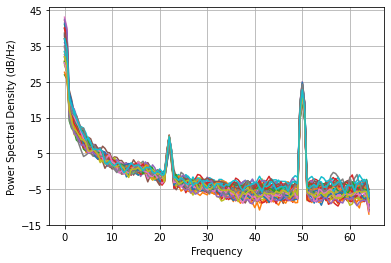

In [447]:
for i in range(40):
    spect_feat[i, :] = spectral_features_resp(resp_signal[i, :], 128)

In [448]:
#Standardizovana obelezja
spect_feat_std = standard(spect_feat)

In [449]:
brv_feat_td = np.zeros((40, 16))
brv_feat_sd = np.zeros((40, 7))

In [450]:
for i in range(40):
    td_i, sd_i = brv_features_resp(resp_signal[i, :], 128)
    brv_feat_sd[i, :] = list(sd_i.values())
    brv_feat_td[i, :] = list(td_i.values())

In [451]:
brv_feat_td_std = standard(brv_feat_td)
brv_feat_sd_std = standard(brv_feat_sd)

In [452]:
cols_td = ['mean_int', 'std_int', 'std_diff_int', 'int_50', 'prop_int_50', 'int_20', 'prop_int_20', 'rmssd', 'median_int', 'int_range', 'cvsd', 'cv_int', 'mean_br', 'max_br', 'min_br', 'std_br']
cols_sd = ['total_pow', 'vlf', 'lf', 'hf', 'lf/hf', 'lf_norm', 'hf_norm']

brv_feat_td_std = pd.DataFrame(brv_feat_td_std, columns=cols_td)
brv_feat_sd_std = pd.DataFrame(brv_feat_sd_std, columns=cols_sd)

In [453]:
spect_feat_std = pd.DataFrame(spect_feat_std, columns=['max_amp', 'mean_band', 'max_psd', 'mean_psd_band'])

In [454]:
resp_features = pd.concat([spect_feat_std, brv_feat_sd_std, brv_feat_td_std], axis=1)

In [455]:
resp_features.to_csv("resp_features/s{}_resp.csv".format(curr))